In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# fashion mnist dataset을 통한 딥러닝 학습 실습을 정리하기 위한 공간임

* 일반적으로 로직은
* functional api 모델 생성 후 pixel 값 조정 및 type 조정
* one hot encoding 적용
* 이후 학습 검증 테스트 데이터로 나눈다
* 마지막으로 complie, 학습/예측/평가

## 데이터 전처리 수행

* 0에서 255 사이의 픽셀값을 0에서 1 사이로 변환. 이 과정을 거쳐야 성능 향상
* array type은 float32. tensorflow도 데이터를 끌어올 떄 자동적으로 float32로 바꾼다
* 전처리를 수행하기 전에 train_labels를 보면 type이 unit8로 되어 있음

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# 전처리를 수행하기 전 데이터들을 보면 type이 unit8임
print(type(train_images[0][0][0]))
print(train_images.shape)

2024-02-04 07:32:25.504887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 07:32:25.505009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 07:32:25.701122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


4422102/4422102 [==============================] - 0s 0us/step
<class 'numpy.uint8'>
(60000, 28, 28)


In [3]:
print(test_images.shape)

(10000, 28, 28)


Text(0.5, 1.0, '9')

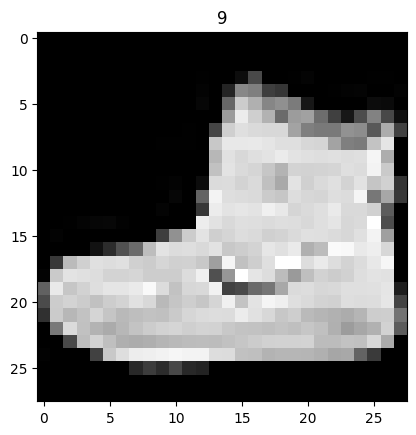

In [4]:
# fashion mnist 데이터 샘플 출력

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap='gray')
plt.title(train_labels[0])

In [5]:
# functional api를 이용한 model 생성

from tensorflow.keras.layers import  Layer, Input, Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

INPUT_SIZE = 28

def create_model():
    input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE))
    x = Flatten()(input_tensor)
    x = Dense(100, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    
    # functional api의 경우 multi input output을 지원하는데 sequentail은 불가능
    model = Model(inputs=input_tensor, outputs=output)
    
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 81840 (319.69 KB)
Trainable params: 81840 (319.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# 데이터 전처리 함수

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 0~1 사잇값의 float32로 전처리

def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0~1 사잇값 float32로 변경하는 함수 호출 후 one hot encoding 적용

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    
    # labels 데이터를 one hot encoding
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 one hot encoding 적용
# 여기서 전처리 및 one hot encoding 과정을 거친 후 학습과 검증 데이터를 분리하면 효율적

def get_train_valid_test_split(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42):
    
    # 학습과 테스트 데이터의 전처리 후 학습이랑 검증 데이터 분리
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습과 검증 데이터 분리
    train_images, valid_images, train_oh_images, valid_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (train_images, train_oh_images), (valid_images, valid_oh_labels), (test_images, test_oh_labels)

In [7]:
# 데이터 전처리 함수를 활용한 실제 데이터 전처리

from tensorflow.keras.datasets import fashion_mnist

# fashion mnist 데이터 재 로딩 및 전처리 적용해서 학습/검증/테스트 데이터 세트 결정
# 데이터 받아오기 / 처음 받아오는 데이터 타입은 numpy.ndarray이다

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(type(train_labels))

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_split(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42)

print((tr_images.shape, tr_oh_labels.shape))  # labels를 보면 one hot encoding이 되어 있다

<class 'numpy.ndarray'>
((51000, 28, 28), (51000, 10))


# loss와 optimizer 설정을 통한 학습 수행
* loss는 categorical_crossentropy로, optimizer는 Adam으로 설정
* categorical crossentropy를 위해서 Label을 one hot encoding으로 변경(keras의 to_categorical을 통해)

In [8]:
from tensorflow.keras.optimizers import Adam

# model 생성 및 optimizer, loss, metric 적용

model = create_model()
model.summary()

# compile을 통해 loss 함수와 optimizer 설정
# one hot encoding이 되었으면 categorical, 아닌 경우 sparse categorical
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 30)                3030      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
Total params: 81840 (319.69 KB)
Trainable params: 81840 (319.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# 학습 수행의 경우 model의 fit을 통해 진행
# history를 통해 결과를 받는다. loss와 accuracy metrics를 받는다
# epoch를 통해 6만개를 batch 수만큼 쪼개서 학습하는데 이걸 epoch 횟수만큼 반복

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=20, validation_data=(val_images, val_oh_labels))

Epoch 1/20


I0000 00:00:1707031963.644760      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


399/399 [==============================] - 4s 4ms/step - loss: 0.5897 - accuracy: 0.7964 - val_loss: 0.4618 - val_accuracy: 0.8378
Epoch 2/20
399/399 [==============================] - 1s 3ms/step - loss: 0.4177 - accuracy: 0.8525 - val_loss: 0.4120 - val_accuracy: 0.8547
Epoch 3/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3754 - accuracy: 0.8654 - val_loss: 0.3866 - val_accuracy: 0.8642
Epoch 4/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3458 - accuracy: 0.8754 - val_loss: 0.3585 - val_accuracy: 0.8721
Epoch 5/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3259 - accuracy: 0.8829 - val_loss: 0.3822 - val_accuracy: 0.8648
Epoch 6/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3155 - accuracy: 0.8851 - val_loss: 0.3555 - val_accuracy: 0.8708
Epoch 7/20
399/399 [==============================] - 1s 4ms/step - loss: 0.2993 - accuracy: 0.8904 - val_loss: 0.3450 - val_accuracy: 0.8757
Epoch 8/20
399/39

In [10]:
history.history

{'loss': [0.5896711349487305,
  0.41771572828292847,
  0.3754328191280365,
  0.3458065986633301,
  0.3259369134902954,
  0.3155412971973419,
  0.2993238866329193,
  0.2881312668323517,
  0.2805613875389099,
  0.2672165036201477,
  0.26188766956329346,
  0.25489556789398193,
  0.2464272677898407,
  0.24137383699417114,
  0.23242823779582977,
  0.22979310154914856,
  0.2235359400510788,
  0.21631233394145966,
  0.2139105349779129,
  0.20539622008800507],
 'accuracy': [0.7964313626289368,
  0.8524901866912842,
  0.8654313683509827,
  0.8754117488861084,
  0.8828823566436768,
  0.8850784301757812,
  0.8904313445091248,
  0.8936470746994019,
  0.8966078162193298,
  0.901411771774292,
  0.9040784239768982,
  0.905803918838501,
  0.9088823795318604,
  0.911098062992096,
  0.9127255082130432,
  0.9147450923919678,
  0.9164901971817017,
  0.9199411869049072,
  0.9194509983062744,
  0.923568606376648],
 'val_loss': [0.46179789304733276,
  0.41204938292503357,
  0.3866032361984253,
  0.3584819734

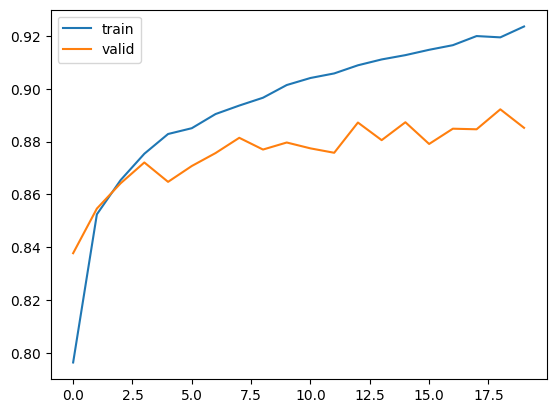

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(hisotry):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

In [12]:
# 테스트 세트로 모델 성능 검증

model.evaluate(x=test_images, y=test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 0s 3ms/step - loss: 0.3529 - accuracy: 0.8812


[0.3528536856174469, 0.8812000155448914]

## callback
* 학습 iteration을 수행할 때 특정 event가 발생하는 경우 호출하는 기능들
* 대표적으로 ModelCheckpoint(), ReduceLROnPlateau(), LearningRateScheduler(), EarlyStopping(), TensorBoard 등이 있음

### ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

* 특정 조건에 맞춰서 모델을 파일에 저장
* filepath: filepath의 경우 on epoch end에서 전달되는 epoch 값과 logs의 키로 채워진 이름 형식 옵션을 가질 수 있다. 예를 들어 filepath가 weights.{epoch:02d}-{val_loss:.2f}.hdf5d인 경우, 파일 이름에 세대 번호와 검증 손실을 넣어 모델의 체크포인트가 저장된다
* monitor: 모니터할 지표(loss 또는 평가 지표) / 대표적으론 val_loss, val_accuracy
* save_best_only: 가장 좋은 성능을 나타내는 모델만 저장할 여부
* save_weights_only: weights만 저장여부 / 성능 및 버그 감소를 위해 True로 두는 것이 좋고, save weights를 통해 저장된 값은 load weights를 통해 다시 불러오면 된다
* mode: {auto, min, max} 중 하나. monitor 지표가 감소해야 좋을 경우, 증가해야 좋은 경우를 구분해서 입력하면 된다. auto로 두면 알아서 분류해주긴 하는데 간혹 틀린 경우가 있어 직접 명시적으로 지정해주는 것이 좋다.
* periods를 길게 설정하면 save weights 같은 작업 반복 주기를 늘릴 수 있다.

In [13]:
# 현재 dir 위치
!pwd

/kaggle/working


In [14]:
# 참고로 keras의 metrics(메트릭이라고 부르기도 함)은 평가지표를 의미한다

from tensorflow.keras.callbacks import ModelCheckpoint

model = create_model()
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

mcp_ob = ModelCheckpoint(filepath='/kaggle/working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
                        save_best_only=True, save_weights_only=True, mode='min', periods=3, verbose=1)
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=10, validation_data=(val_images, val_oh_labels),
                   callbacks=[mcp_ob])

Epoch 1/10
394/399 [============================>.] - ETA: 0s - loss: 0.5422 - accuracy: 0.8098
Epoch 1: val_loss improved from inf to 0.43803, saving model to /kaggle/working/weights.01-0.44.hdf5
399/399 [==============================] - 2s 4ms/step - loss: 0.5401 - accuracy: 0.8105 - val_loss: 0.4380 - val_accuracy: 0.8456
Epoch 2/10
389/399 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8552
Epoch 2: val_loss improved from 0.43803 to 0.41063, saving model to /kaggle/working/weights.02-0.41.hdf5
399/399 [==============================] - 1s 3ms/step - loss: 0.4014 - accuracy: 0.8554 - val_loss: 0.4106 - val_accuracy: 0.8548
Epoch 3/10
396/399 [============================>.] - ETA: 0s - loss: 0.3695 - accuracy: 0.8647
Epoch 3: val_loss improved from 0.41063 to 0.41035, saving model to /kaggle/working/weights.03-0.41.hdf5
399/399 [==============================] - 1s 3ms/step - loss: 0.3698 - accuracy: 0.8646 - val_loss: 0.4103 - val_accuracy: 0.8539
Epoch 4/

In [15]:
# 위 과정을 통해 save best only option으로 인해 여러개의 파이이 만들어진다

!ls -lia

!rm -rf weight*
!ls -lia

total 2404
   786440 drwxr-xr-x 2 root root   4096 Feb  4 07:33 .
268744977 drwxr-xr-x 6 root root   4096 Feb  4 07:32 ..
   786441 ---------- 1 root root 363844 Feb  4 07:33 __notebook__.ipynb
   786442 -rw-r--r-- 1 root root 344080 Feb  4 07:33 weights.01-0.44.hdf5
   786443 -rw-r--r-- 1 root root 344080 Feb  4 07:33 weights.02-0.41.hdf5
   786444 -rw-r--r-- 1 root root 344080 Feb  4 07:33 weights.03-0.41.hdf5
   786445 -rw-r--r-- 1 root root 344080 Feb  4 07:33 weights.04-0.38.hdf5
   786446 -rw-r--r-- 1 root root 344080 Feb  4 07:33 weights.05-0.36.hdf5
   786447 -rw-r--r-- 1 root root 344080 Feb  4 07:33 weights.09-0.36.hdf5
total 364
   786440 drwxr-xr-x 2 root root   4096 Feb  4 07:33 .
268744977 drwxr-xr-x 6 root root   4096 Feb  4 07:32 ..
   786441 ---------- 1 root root 363844 Feb  4 07:33 __notebook__.ipynb


### ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
* 특정 epoch 횟수 동안 성능이 개선되지 않을 시 learning rate를 동적으로 감소시킨다
* monitor: 모니터할 지표로, loss 또는 여러 평가 지표
* factor: 학습 속도를 줄일 인수, new_lr = lr(기존 learning rate) * factor
* patience: Learning rate를 줄이기 전에 monitor할 epochs 횟수
* mode: auto, min, max 중 하나

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitors='val_loss', factor=0.3, patience=3, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels),
                   callbacks=[rlr_cb])

Epoch 1/30
399/399 [==============================] - 2s 4ms/step - loss: 0.6277 - accuracy: 0.7855 - val_loss: 0.4578 - val_accuracy: 0.8371 - lr: 0.0010
Epoch 2/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4111 - accuracy: 0.8547 - val_loss: 0.4161 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 3/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3728 - accuracy: 0.8670 - val_loss: 0.3681 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 4/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3490 - accuracy: 0.8748 - val_loss: 0.3730 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 5/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3306 - accuracy: 0.8798 - val_loss: 0.3527 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 6/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3112 - accuracy: 0.8877 - val_loss: 0.3457 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - lo

### EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
* 특정 epochs 동안 성능이 개선되지 않을 시 학습을 조기에 중단
* monitor: 모니터할 지표
* patience: early stopping 적용 전에 monitor할 epochs 횟수
* mode: auto min max 중 선택

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

ely_cb = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels),
                   callbacks=[ely_cb])

Epoch 1/30
399/399 [==============================] - 2s 4ms/step - loss: 0.6070 - accuracy: 0.7921 - val_loss: 0.4558 - val_accuracy: 0.8396
Epoch 2/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4105 - accuracy: 0.8530 - val_loss: 0.4218 - val_accuracy: 0.8518
Epoch 3/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3736 - accuracy: 0.8652 - val_loss: 0.3806 - val_accuracy: 0.8601
Epoch 4/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3454 - accuracy: 0.8738 - val_loss: 0.3608 - val_accuracy: 0.8723
Epoch 5/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3259 - accuracy: 0.8824 - val_loss: 0.3546 - val_accuracy: 0.8730
Epoch 6/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3127 - accuracy: 0.8867 - val_loss: 0.3469 - val_accuracy: 0.8713
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - loss: 0.2966 - accuracy: 0.8917 - val_loss: 0.3339 - val_accuracy: 0.8807
Epoch 

In [18]:
!rm weigh*

rm: cannot remove 'weigh*': No such file or directory


In [19]:
# 보통은 위 callback들을 따로 쓰지 않고 한번에 다같이 쓴다

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

mcp_cb = ModelCheckpoint(filepath='/kaggle/working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                         save_best_only=True, save_weights_only=True, mode='min', period=1, verbose=0)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=40, validation_data=(val_images, val_oh_labels),
                   callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/40
 55/399 [===>..........................] - ETA: 22s - loss: 1.1247 - accuracy: 0.6193

IOStream.flush timed out


399/399 [==============================] - 16s 12ms/step - loss: 0.5945 - accuracy: 0.7956 - val_loss: 0.4598 - val_accuracy: 0.8388 - lr: 0.0010
Epoch 2/40
399/399 [==============================] - 1s 3ms/step - loss: 0.4096 - accuracy: 0.8564 - val_loss: 0.3950 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 3/40
399/399 [==============================] - 1s 3ms/step - loss: 0.3732 - accuracy: 0.8648 - val_loss: 0.3863 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 4/40
399/399 [==============================] - 1s 3ms/step - loss: 0.3472 - accuracy: 0.8757 - val_loss: 0.3531 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 5/40
399/399 [==============================] - 1s 3ms/step - loss: 0.3253 - accuracy: 0.8823 - val_loss: 0.3466 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 6/40
399/399 [==============================] - 1s 3ms/step - loss: 0.3127 - accuracy: 0.8857 - val_loss: 0.3444 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 7/40
399/399 [==============================] - 1s 3ms/step - loss: 0.297

# Convolutional Neural Network를 통한 feature extraction

### Conv2D를 통한 구현
* 위에서 구현한 일반 dense layer만을 이용한 이미지 classification시에 생기는 문제가 2가지가 있다
* 먼저 분류 대상이 이미지의 어디에 있을지 알 수 없다
* 이미지의 크기가 클수록 이를 위한 너무 많은 weight가 필요하다
* 이를 위해 고안된 방식이 convolutional neural network를 통한 feature extracting 방식이고, keras에선 이를 layers의 Conv2D를 통해 구현한다.

In [20]:
# Conv2D 구현 예시

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

# 이전에 만들었던 model의 input tensor에서 봤듯이 keras에서 모델 생성 시 batch를 고려하지 않았다.
# 그래서 우리도 2차원 배열을 shape로 넣어줬다
# 그러나 keras layer의 conv2d는 batch를 제외하고도 3차운을 받는다. 이는 shape에서 channel의 공간을 고려했기 때문이다.
# 해당 channel의 경우 tensorflow는 channel 정보를 무조건 뒤에서 받기 때문이다.
input_tensor = Input(shape=(28,28,1))

# padding 옵션의 경우, same이면 con2d 연산 전후 사이즈가 28*28로 갖게 맞춰진다.
x = Conv2D(filters=4, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)

conv2d_model = Model(inputs=input_tensor, outputs=x)
conv2d_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 4)         40        
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Pooling 적용하기
* pooling이란, 앞서서 conv2d layer의 계산 결과인 feature maps를 일종의 subsampling하는 과정이다.

#### Pooling의 목적은 아래와 같다
1. input size를 줄여 텐서의 크기를 줄여 계산 속도를 높이기.
2. input size 감소를 통한 불필요한 parameter 제거로 overfitting 조절

In [21]:
# pooling을 적용한 모델 구현 예시

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# maxpooling2d를 통해 channel의 수는 변하지 않고 평면적인 사이즈는 28*28에서 14*!4로 축소

input_tensor = Input(shape=(28,28,1))
x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)
print(x)

pooling_model = Model(inputs=input_tensor, outputs=x)
# summary에서 maxpooling의 경우 기존에 있는 feature map에 연산을 통해 shape를 줄이는 역할을 수행했기에 parameter는 따로 없다
# 첫 번째 conv2d에서 param수가 160인 이유는 kernel_size 3*3이 16개가 있고, 거기에 bias가 filter 개수만큼 붙어서 (3*3)*16 + 16 = 160이다.
# 두 번째 conv2d의 pararm수는 한 filter에 3*3으로 구성된 kernel이 16개가 있다. 그렇게 구성된 filter가 32개가 있고 여기에 bias 32개가 붙어서 (3*3*16)*32 + 32 = 4640이다.
# 결국 위처럼 구성된 cnn의 연산을 거쳐서 최적 feature 추출을 위한 필터 weight 값이 계산된다.
pooling_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 13, 32), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
Total params: 4800 (18.75 KB)
Trainable params: 4800 (18.75 KB)
Non-trainable params: 0 

# feature extractor와 classifier를 합친 model 생성

In [22]:
from tensorflow.keras.layers import  Input,Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# feature extractor
input_tensor = Input(shape=(28,28,1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

# classifier
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 10816)             0         
                                                                 
 dense_18 (Dense)            (None, 100)               1081700   
                                                           

## fashion mnist 데이터를 사용한 모델 학습 및 평가

In [23]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=20, validation_data=(val_images, val_oh_labels))

Epoch 1/20
399/399 [==============================] - 7s 9ms/step - loss: 0.4407 - accuracy: 0.8459 - val_loss: 0.3099 - val_accuracy: 0.8872
Epoch 2/20
399/399 [==============================] - 3s 7ms/step - loss: 0.2734 - accuracy: 0.9024 - val_loss: 0.2672 - val_accuracy: 0.9034
Epoch 3/20
399/399 [==============================] - 3s 7ms/step - loss: 0.2215 - accuracy: 0.9204 - val_loss: 0.2428 - val_accuracy: 0.9114
Epoch 4/20
399/399 [==============================] - 3s 7ms/step - loss: 0.1855 - accuracy: 0.9315 - val_loss: 0.2554 - val_accuracy: 0.9090
Epoch 5/20
399/399 [==============================] - 3s 7ms/step - loss: 0.1548 - accuracy: 0.9444 - val_loss: 0.2206 - val_accuracy: 0.9166
Epoch 6/20
399/399 [==============================] - 3s 7ms/step - loss: 0.1298 - accuracy: 0.9533 - val_loss: 0.2455 - val_accuracy: 0.9158
Epoch 7/20
399/399 [==============================] - 3s 7ms/step - loss: 0.1092 - accuracy: 0.9596 - val_loss: 0.2287 - val_accuracy: 0.9192
Epoch 

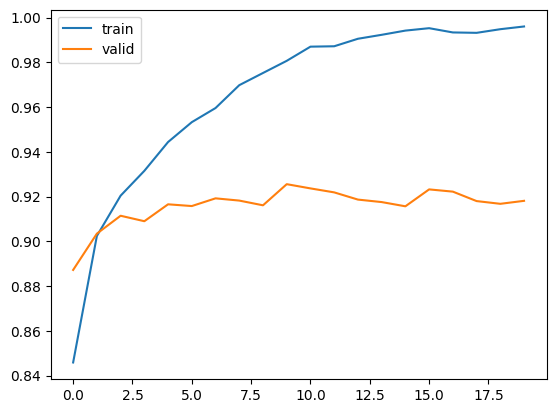

In [25]:
show_history(history)

In [26]:
# 기존에 위에서 feature extraction 과정 없이 진행한 모델에 비해 훨씬 낫다.

model.evaluate(test_images, test_oh_labels, batch_size=128, verbose=1)

79/79 [==============================] - 0s 5ms/step - loss: 0.4835 - accuracy: 0.9200


[0.4835459887981415, 0.9200000166893005]